# Fee Mechanism Scenarios

In [1]:
import plotly.io as pio
pio.renderers.default = "png"

import sys
sys.path.append('../')

from aztec_gddt.analysis.execute import execute_sim, complexity_desc
from aztec_gddt.analysis.visualizations import plot_agg_kpis, plot_inspect_vars
from aztec_gddt.analysis.metrics import *
from aztec_gddt.scenario_experiments import *

## Summary

The **Fee Mechanism** scenario group is a series of simulations designed to help inform the specification of protocol parameters assumed to impact the fee mechanism. The scenarios cover a variety of different environments for the base fee by simulating different "shocks". Different combinations of control and environmental parameter values generate different simulation outcomes, that can be summarized by key peformance indicators (KPIs). The KPIs are then assessed according to desired values (success criteria), using threshold inequalities generated from threshold values for KPIs that meet stakeholder criteria.
Specifically, this scenario group covers four subgroups:
i) Volatility
The volatility scenario tests the effect of secondary market volatility on the volatility of the Base Fee as well as the proftibality of the Sequencer and the Prover

ii) L2 Cost Censorship
The L2 Cost Censorship scenario tests relative inclusion of L2 transactions by simulating user generated max fee per mana values and comparing them to base fee realizations. 

iii) Shock Analysis
The Shock Analysis scenario tests the effects of L2 network congestion and L1 network congestion (represented through L1 gas prices) on the base fee dynamics. 

iv) Oracle Sensitivity
The Oracle Sensitivity scenario tests the susceptibility of the fee mechanism to small errors propagating via the oracle channel, where "real" values can diverge from those used for computation ("oracle values") by "lagging behind" (slower update frequency and slower magnitude of change).

## 1. Volatility

In [2]:
exp_spec = experiment_feemech_volatility

# Override default configuration
exp_spec.N_timesteps = 1_000
exp_spec.N_samples = 1
exp_spec.N_config_sample = 10

CONTROL_PARAMS = list(exp_spec.params_swept_control.keys())

sim_df, exec_time = execute_sim(exp_spec.prepare())
agg_df, c_agg_df = retrieve_feature_df(sim_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 43, 10, 32)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 43, 10, 32)


Initializing configurations:   0%|          | 0/10 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/70010 [00:00<?, ?it/s]

Total execution time: 3.79s


### Objective 
The current computation for the fee mechanism requires a conversion from Wei to Fee Asset. This implies that secondary market volatility of that asset pair has effects on each realization of a base fee and as such presents an uncertain outcome on quality of service for End Users and service provisioning by Sequencers and Provers. 
This scenario tests the propagation of secondary market volatility of the Fee Asset price to 1) the volatility of the Base Fee, denominated in terms of Fee Asset per mana, 2) the profitability of the sequencer, and 3) the profitability of the prover.

### Experimental Setup

#### Testing Variables: 
:dart: we should check tthe below variables 

##### Environmental:
* Introduce different exchange rate realizations, by varying variance and mean. Exchange rate scenarios are modeled as particular shocks, where they either:
i) strictly increase at maximum change throughout the simulation 
ii) strictly decrease at maximum change throughout the simulation 
iii) new values are drawn randomly from within the allowed range
iv) stagnate without much change throughout the simulation
This is a proxy for different environmental realizations of secondary market effects on the base fee. 


##### Protocol: 
Assess the impact of different Base Fee related values. As the Base Fee is computed from various parametrizable components, this scenario tests a first group of parameter choices. This group consists of:
i)`OVERHEAD_MANA_PER_TX` - Each transaction incurs overhead mana costs, irrespective of any conducted operations. 
ii) `MAXIMUM_MANA_PER_BLOCK` - Each block is limited in *size* by this value, affecting profitability of sequencers, throughput of the network, and the computation of base fees directly. 
iii) `TARGET_MANA_PER_BLOCK` - This value is needed to compute the congestion component of the base fee. 
iv) `MAXIMUM_FEE_JUICE_PER_WEI_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real secondary market price updates. In other words, the real secondary market price can fluctuate freely (such as in a flashcrash), while the oracle value used in practice by users is limited in change. Through this the base fee might lag behind in its conversion component when compared to a "real" secondary market price value used in computation. 
v) `MAXIMUM_PROVING_COST_WEI_PER_MANA_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real proving cost updates. In other words, the proving cost experienced by Provers might differ from the oracle value used in practice by users. Through this the base fee might lag behind in its proving cost component when compared to a "real" secondary market price value used in computation. 

#### Simulation input/output per Monte Carlo run:

##### Input:
For each parameter constellation of interest, we draw a simulated time series of secondary market Fee Asset price used to pay the transaction fee, parameterized by moments of distribution (mean, variance).

##### Output:  
- $\mathcal{M}$ Monte Carlo runs indexed by $m$.
- Time series of the Base Fee denominated in Fee Asset per mana
- Number of empty slots per epoch, for each $m$th Monte Carlo run.

#### Sweep Parameters:
Refer to the [spreadsheet](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=955157985#gid=955157985&range=A1) for detailed parameter configurations related to staking and slashing mechanisms.

:dart: Fill in :dart:

##### Control:

In [3]:
exp_spec.print_control_params()

RELATIVE_TARGET_MANA_PER_BLOCK: [0.5, 0.9]
MAXIMUM_MANA_PER_BLOCK: [20000000, 40000000]
MINIMUM_MULTIPLIER_CONGESTION: [1000000, 4000000, 10000000]
RELATIVE_UPDATE_FRACTION_CONGESTION: [0.1, 1.0, 10.0]
OVERHEAD_MANA_PER_TX: [1000, 10000, 50000]
MAXIMUM_UPDATE_PERCENTAGE_C: [0.01, 0.03]


##### Environmental:

In [4]:
exp_spec.print_env_params()

JUICE_PER_WEI_MEAN: [1.1e-15, 1e-14]
JUICE_PER_WEI_COV: [0.03, 0.3]


#### Simulation Behavior:
1. A sequencer will not post a block to L1 if the revenue from the block is less than the cost of posting the block.
2. A prover will not post a proof to L1 if the revenue from proving is less than the cost of posting the block.

#### Threshold Inequalities:

#### Metrics:
1. **Average relative volatility:** $\bar{(\frac{\sigma_B}{\sigma_A})}$, where the average is taken over the $\mathcal{M}$ MC runs of the values $\sigma_B^m$/$\sigma_A^m$, $m = 1 , … ,\mathcal{M}$, and $\sigma_A^m$ and $\sigma_B^m$ are the volatility measures for the ASSET time series and BASE FEE time series for MC run $m$, respectively.
Interpretation: A value of the metric greater than 1 indicates that ASSET price volatility is amplified, while a volatility less than 1 indicates that ASSET price volatility is attenuated.

    
2. Average number of empty block slots over the $\mathcal{M}$ MC runs
Interpretation: A large number of empty slots implies that posting blocks to L1 is unprofitable for a sequencer.


3. Average number of unproven epochs over the $\mathcal{M}$ MC runs
Interpretation: A large number of unproven epochs implies that posting proofs to L1 is unprofitable for a prover.



### Computational Complexity

In [5]:
print(complexity_desc(sim_df, exec_time))


    #### Computational Complexity:
    1. Total number of parameter combinations: 10
    2. Total number of Monte Carlo runs per parameter combination: 10
    3. Total number of trajectories: 10
    4. Total number of timesteps per trajectory: 1,000
    5. Total number of state measurements: 10,010
    6. Workflow execution time: 6.37 seconds (0.637 seconds per trajectory)
    7. Engine execution time: 3.79 seconds (0.379 seconds per trajectory)
    


### Simulation Results 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart: 

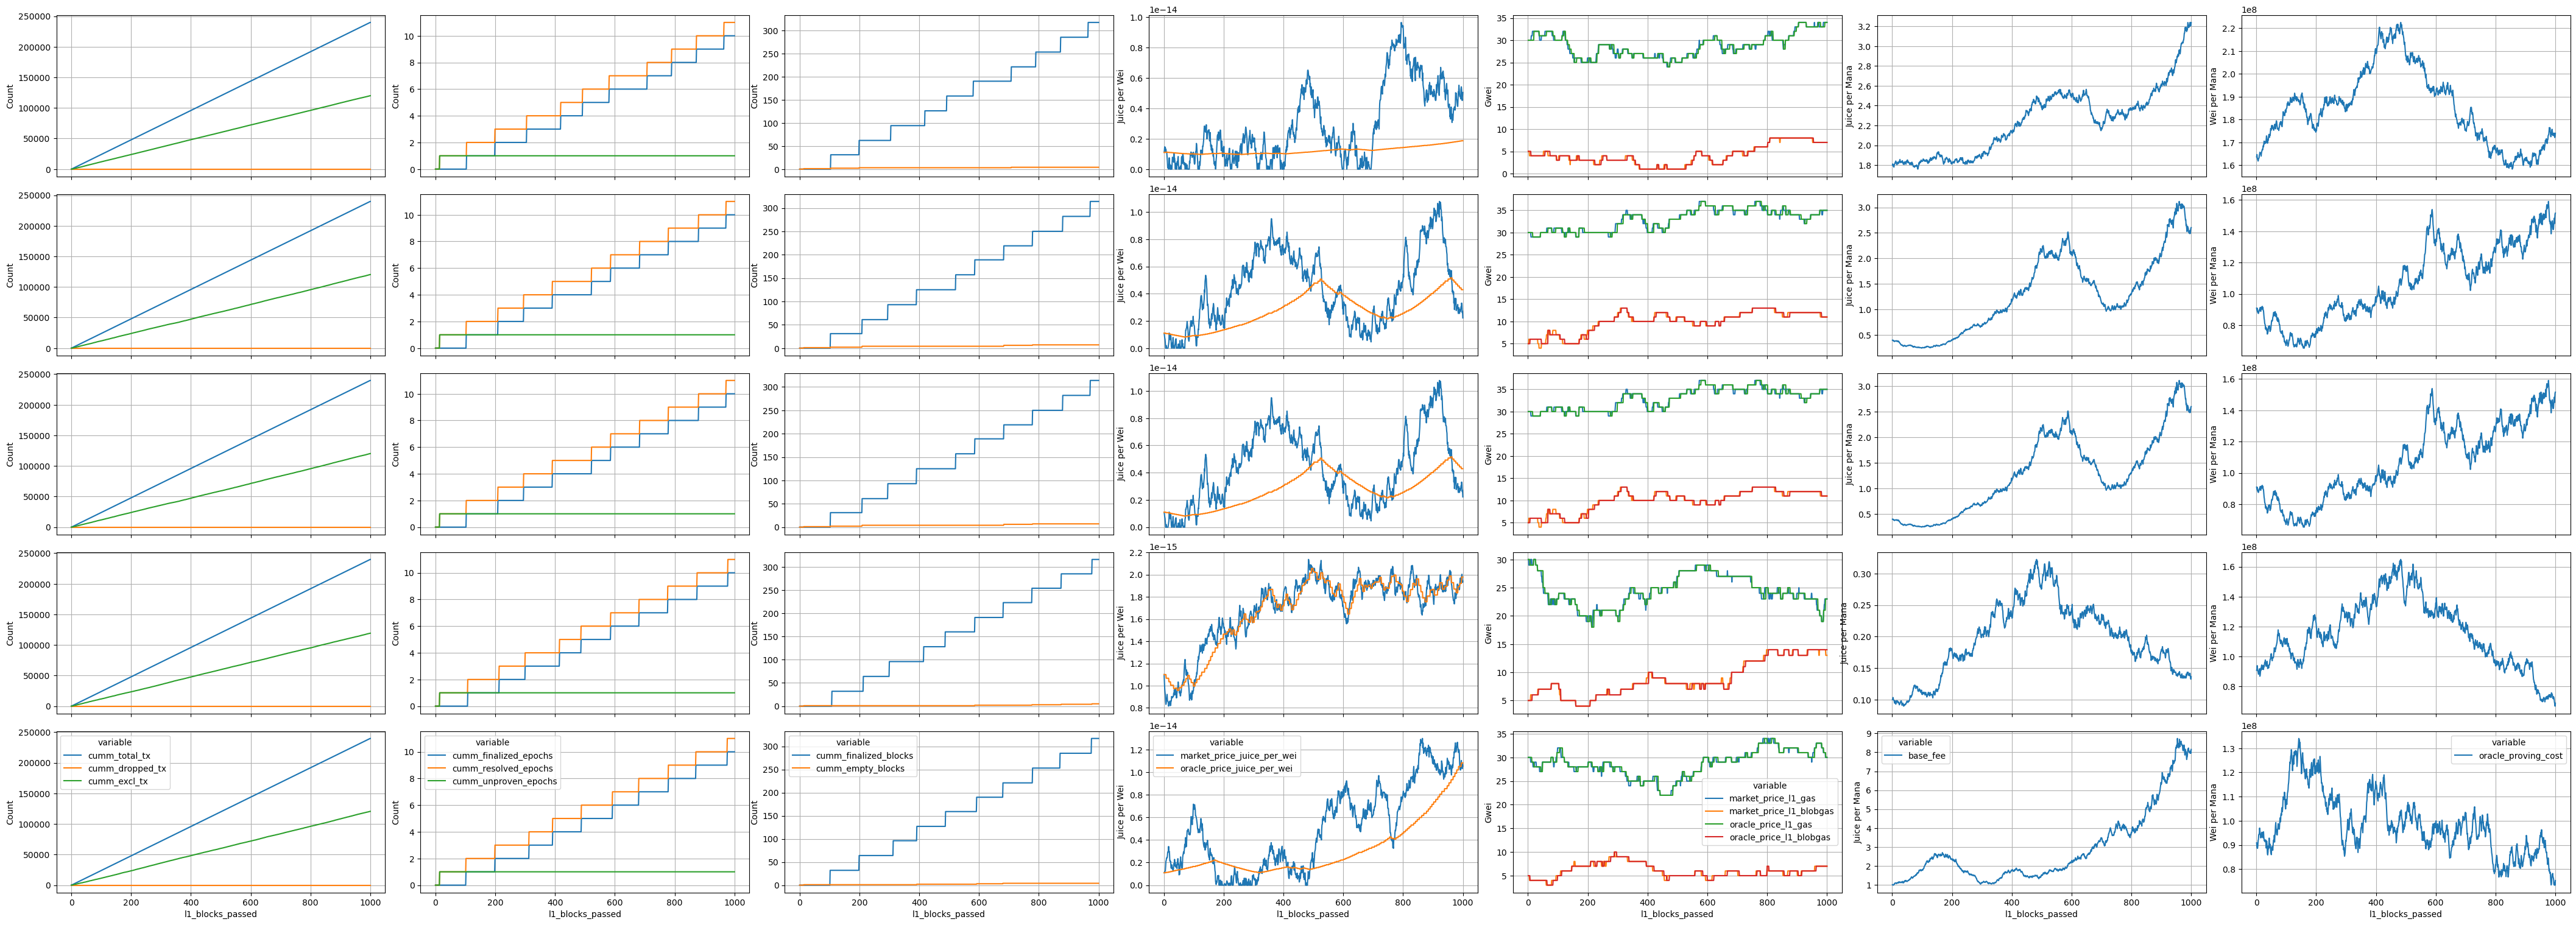

In [6]:
plot_inspect_vars(sim_df)

### Protocol Parameter Recommendations 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over table :dart: 
- [ ] :dart: Generate an analogue table below for the results :dart: 


| Control Parameter | Recommended Range | Unit |
| - | - | - |
| RELATIVE_TARGET_MANA_PER_BLOCK | tbd | Mana |
| MAXIMUM_MANA_PER_BLOCK | tbd | Mana |
| MINIMUM_MULTIPLIER_CONGESTION | tbd | Unitless |
| UPDATE_FRACTION_CONGESTION | tbd | 1 / Mana |
| OVERHEAD_MANA_PER_TX | tbd | Mana |
| PROVING_COST_MODIFIER_INITIAL_C | tbd | Mana |
| FEE_JUICE_PRICE_MODIFIER_INITIAL_C | tbd | Juice per Wei |
| MAXIMUM_UPDATE_PERCENTAGE_C | tbd | Unitless |

### Decision Tree and Parameter Importance

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::
- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart:

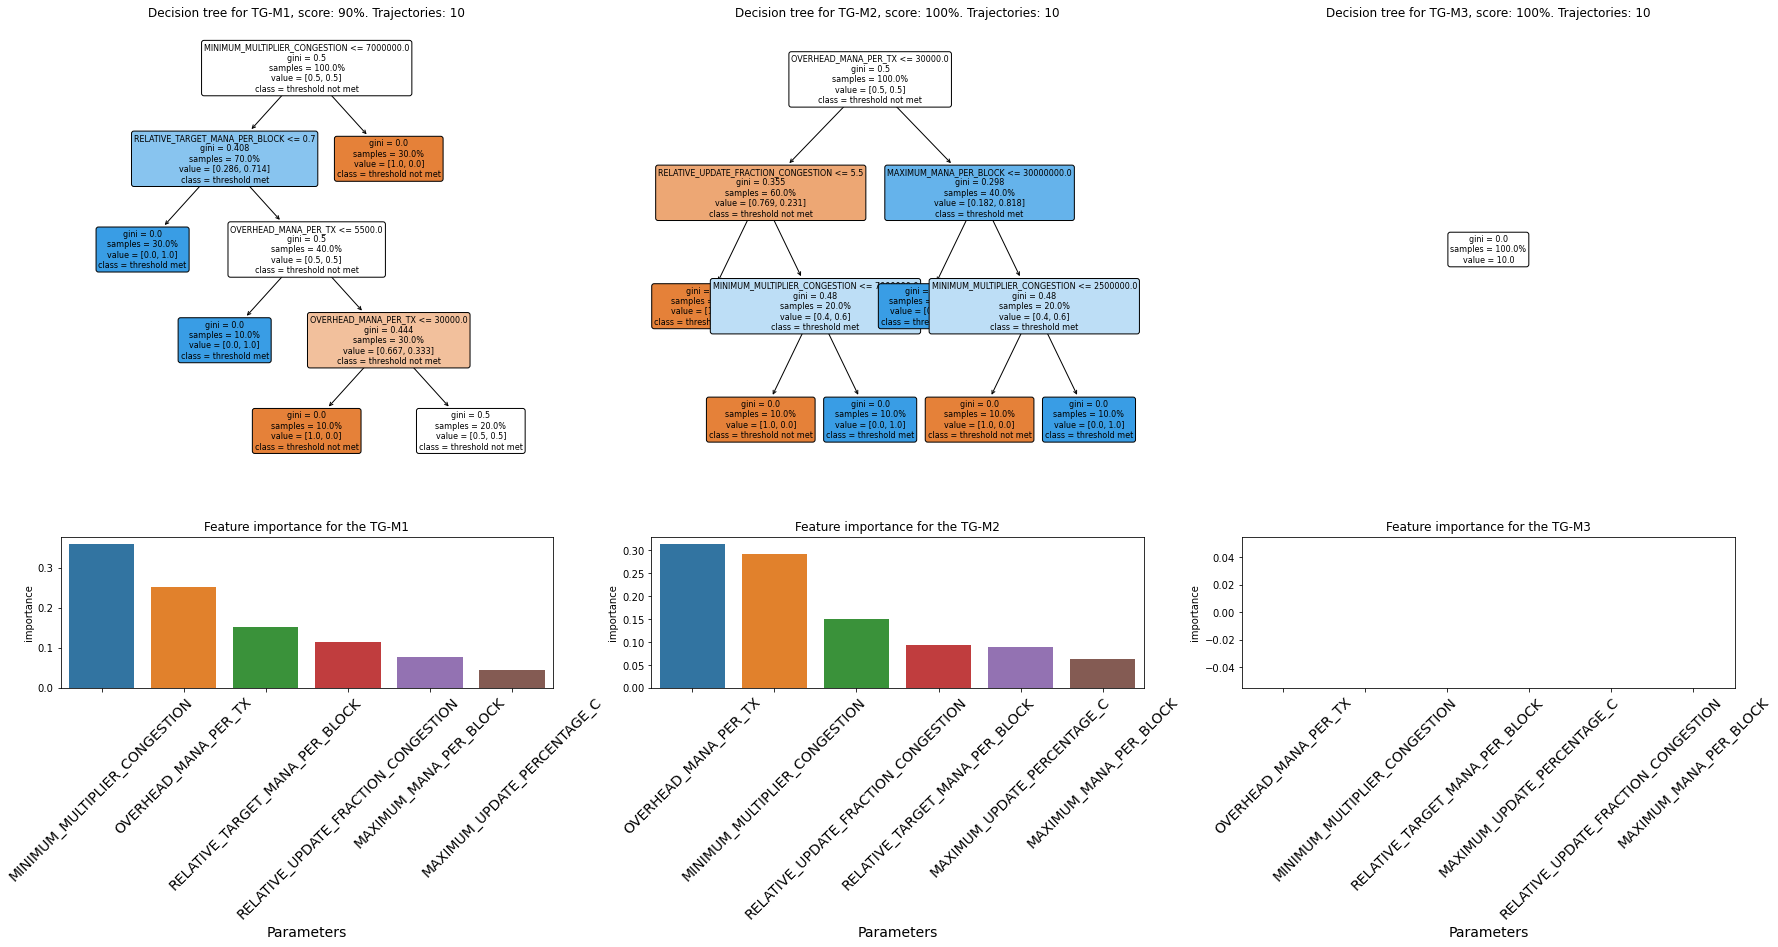

In [7]:
plot_agg_kpis(c_agg_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)

### Commentary on Results:

:dart: Write anything that comes up to mind based on the interpretation over all the results :dart: 

## Conclusion

- [ ] 🔫 Jakob owns after Danilo wrote commentary on results 🔫

## Appendix:
### Parameter Impact on Metrics: 

## 2. L2 Cost Censorship

In [8]:
exp_spec = experiment_feemech_l2_cost_censorship

# Override default configuration
exp_spec.N_timesteps = 1_000
exp_spec.N_samples = 1
exp_spec.N_config_sample = 10

CONTROL_PARAMS = list(exp_spec.params_swept_control.keys())

sim_df, exec_time = execute_sim(exp_spec.prepare())
agg_df, c_agg_df = retrieve_feature_df(sim_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 43, 10, 32)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 43, 10, 32)


Initializing configurations:   0%|          | 0/10 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/70010 [00:00<?, ?it/s]

Total execution time: 4.57s


### Objective 
As the fee mechanism can return a different base fee at each timestep, users must specify a max fee per mana value up to which they accept paying for a rising base fee. This implies that for UX purposes, a highly volatile base fee computation might render reasonably set max fee per mana values infeasible, as the base fee deviates too much until the time to inclusion.
This scenario tests the relative inclusion of transactions given sequencer profitability, based upon the requirement that the maximum fee per mana for any (included) transaction must at least cover the estimated base fee per mana cost in a dynamically adjusting environment. By simulating shocks in the environment, which propagate into the fee mechanism computation, insights can be gained on potential effects of transactions inclusion under different max fee per mana assumptions.

### Experimental Setup

#### Testing Variables: 
:dart: we should check tthe below variables 

##### Environmental:
* Introduce a simulated max fee per mana time series which allows for measuring their expected inclusion.
* Shock scenarios on secondary market exchange rate, gas prices, proving cost:
	i) strictly increase at maximum change throughout the simulation 
	ii) strictly decrease at maximum change throughout the simulation 
	iii) new values are drawn randomly from within the allowed range
	iv) stagnate without much change throughout the simulation

* Assess the impact of different Base Fee related values. As the Base Fee is computed from various parametrizable components, this scenario tests a first group of parameter choices. This group consists of:
i)`OVERHEAD_MANA_PER_TX` - Each transaction incurs overhead mana costs, irrespective of any conducted operations. 
ii) `MAXIMUM_MANA_PER_BLOCK` - Each block is limited in *size* by this value, affecting profitability of sequencers, throughput of the network, and the computation of base fees directly. 
iii) `TARGET_MANA_PER_BLOCK` - This value is needed to compute the congestion component of the base fee. 
iv) `MAXIMUM_FEE_JUICE_PER_WEI_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real secondary market price updates. In other words, the real secondary market price can fluctuate freely (such as in a flashcrash), while the oracle value used in practice by users is limited in change. Through this the base fee might lag behind in its conversion component when compared to a "real" secondary market price value used in computation. 
v) `MAXIMUM_PROVING_COST_WEI_PER_MANA_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real proving cost updates. In other words, the proving cost experienced by Provers might differ from the oracle value used in practice by users. Through this the base fee might lag behind in its proving cost component when compared to a "real" secondary market price value used in computation. 

#### Simulation input/output per Monte Carlo run:

##### Input:
Simulated time series of transactions with different MAX FEE PER MANA amounts, parameterized by moments of distribution of MAX FEE PER MANA (mean, variance) at each block

##### Output:  
- Transactions included in each block; Transactions dropped from each block
Monte Carlo ($M$ runs indexed by $m$):
For each parameter constellation of interest, draw $M$ realizations of transaction time series


#### Sweep Parameters:
Refer to the [spreadsheet](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=955157985#gid=955157985&range=A1) for detailed parameter configurations related to staking and slashing mechanisms.

:dart: Fill in :dart:

##### Control:


In [9]:
exp_spec.print_control_params()

MAX_FEE_INFLATION_RELATIVE_STD: [0.05, 0.1, 0.2]
RELATIVE_TARGET_MANA_PER_BLOCK: [0.5, 0.9]
MAXIMUM_MANA_PER_BLOCK: [20000000, 40000000]
MINIMUM_MULTIPLIER_CONGESTION: [1000000, 4000000, 10000000]
RELATIVE_UPDATE_FRACTION_CONGESTION: [0.1, 1.0, 10.0]
OVERHEAD_MANA_PER_TX: [1000, 10000, 50000]
MAXIMUM_UPDATE_PERCENTAGE_C: [0.01, 0.03]


##### Environmental:

In [10]:
exp_spec.print_env_params()

MAX_FEE_INFLATION_RELATIVE_MEAN: [0.5, 1.0, 1.5]
MAX_FEE_INFLATION_RELATIVE_STD: [0.02, 0.1, 0.5]


#### Simulation Behavior:
1. A sequencer will not post a block to L1 if the revenue from the block is less than the cost of posting the block.
2. A prover will not post a proof to L1 if the revenue from proving is less than the cost of posting the block. 

#### Threshold Inequalities:

#### Metrics:
1. Average percentage of dropped transactions: $\bar{(\frac{T_I}{T_I+T_D})}$, where the average is taken over the $M$ MC runs of values $\frac{T_I^m}{T_I^m+{T_D^m}}$ and $T_I^m$ and $T_D^m$ are the total transactions included and dropped for MC run $m$, respectively.
Interpretation: Average percentage of dropped transactions: A high value indicates many transactions are dropped, while a low value indicates few values are dropped.
2. Percentage of MC runs above dropped threshold ([PERCENTAGE_CENSORSHIP_LIMIT_M](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=1840722092#gid=1840722092&range=A39)): The proportion of all MC runs for which the average percentage of dropped transactions was less than a THRESHOLD AMOUNT.
Interpretation: Percentage of MC runs above dropped threshold: The percentage of Monte Carlo runs where the fraction of L2 transactions censored due to cost remains below a threshold.

**Inflation term:**
- For each run, the mean μB of the distribution of MAX FEE PER MANA for a block B is set using the following rule:
- μB:=(1+π)FB−1, where π is an inflation term that is swept over and FB−1 is the base fee for the immediately previous block.
- Intuitively, any transaction with MAX FEE PER MANA μB will be included if μB≥FB and dropped otherwise.

#### Computational Complexity:

In [11]:
print(complexity_desc(sim_df, exec_time))


    #### Computational Complexity:
    1. Total number of parameter combinations: 10
    2. Total number of Monte Carlo runs per parameter combination: 10
    3. Total number of trajectories: 10
    4. Total number of timesteps per trajectory: 1,000
    5. Total number of state measurements: 10,010
    6. Workflow execution time: 7.31 seconds (0.731 seconds per trajectory)
    7. Engine execution time: 4.57 seconds (0.457 seconds per trajectory)
    


### Simulation Results 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart: 

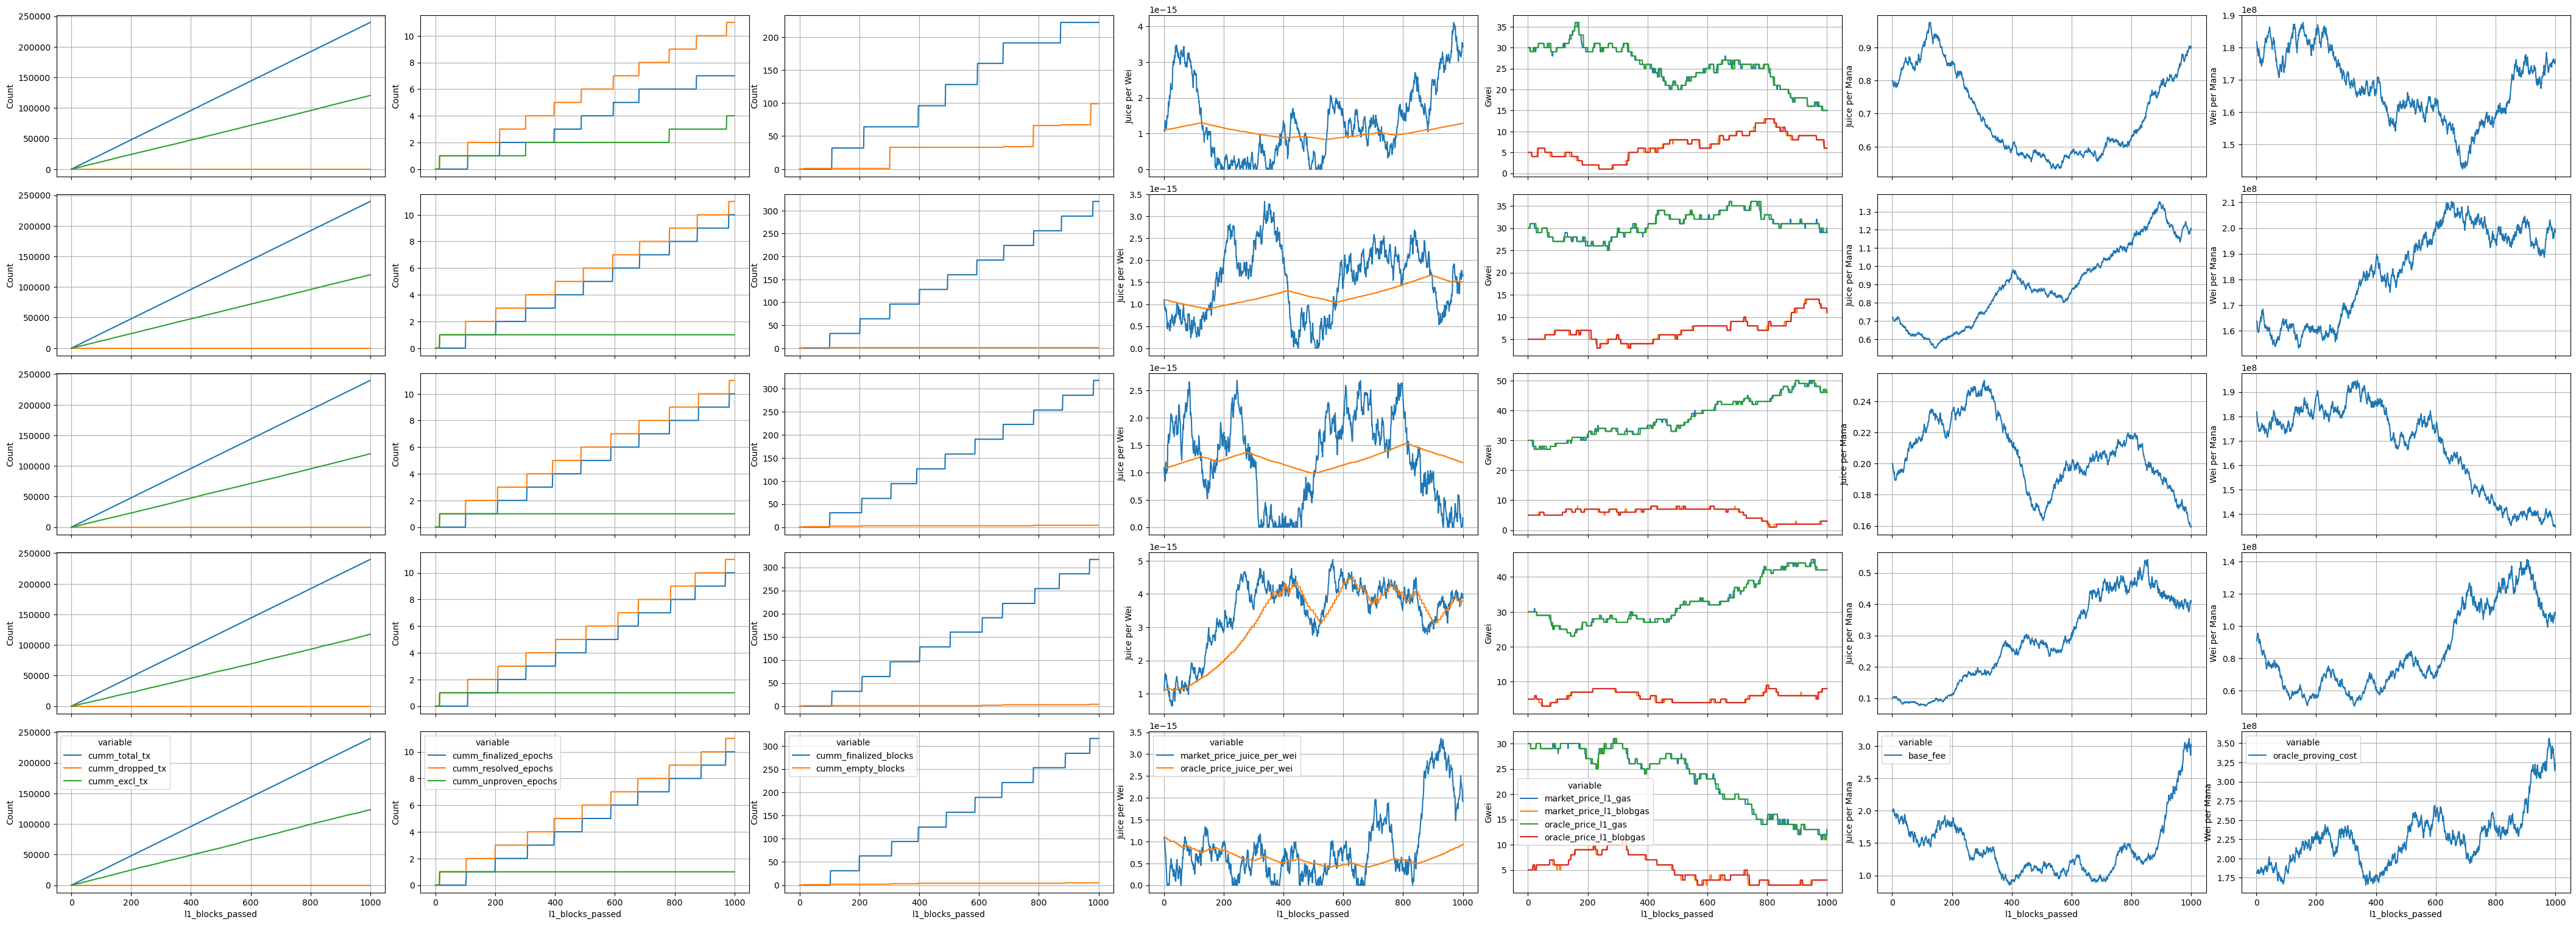

In [12]:
plot_inspect_vars(sim_df)

### Protocol Parameter Recommendations 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over table :dart: 
- [ ] :dart: Generate an analogue table below for the results :dart: 

### Decision Tree and Parameter Importance

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::
- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart:

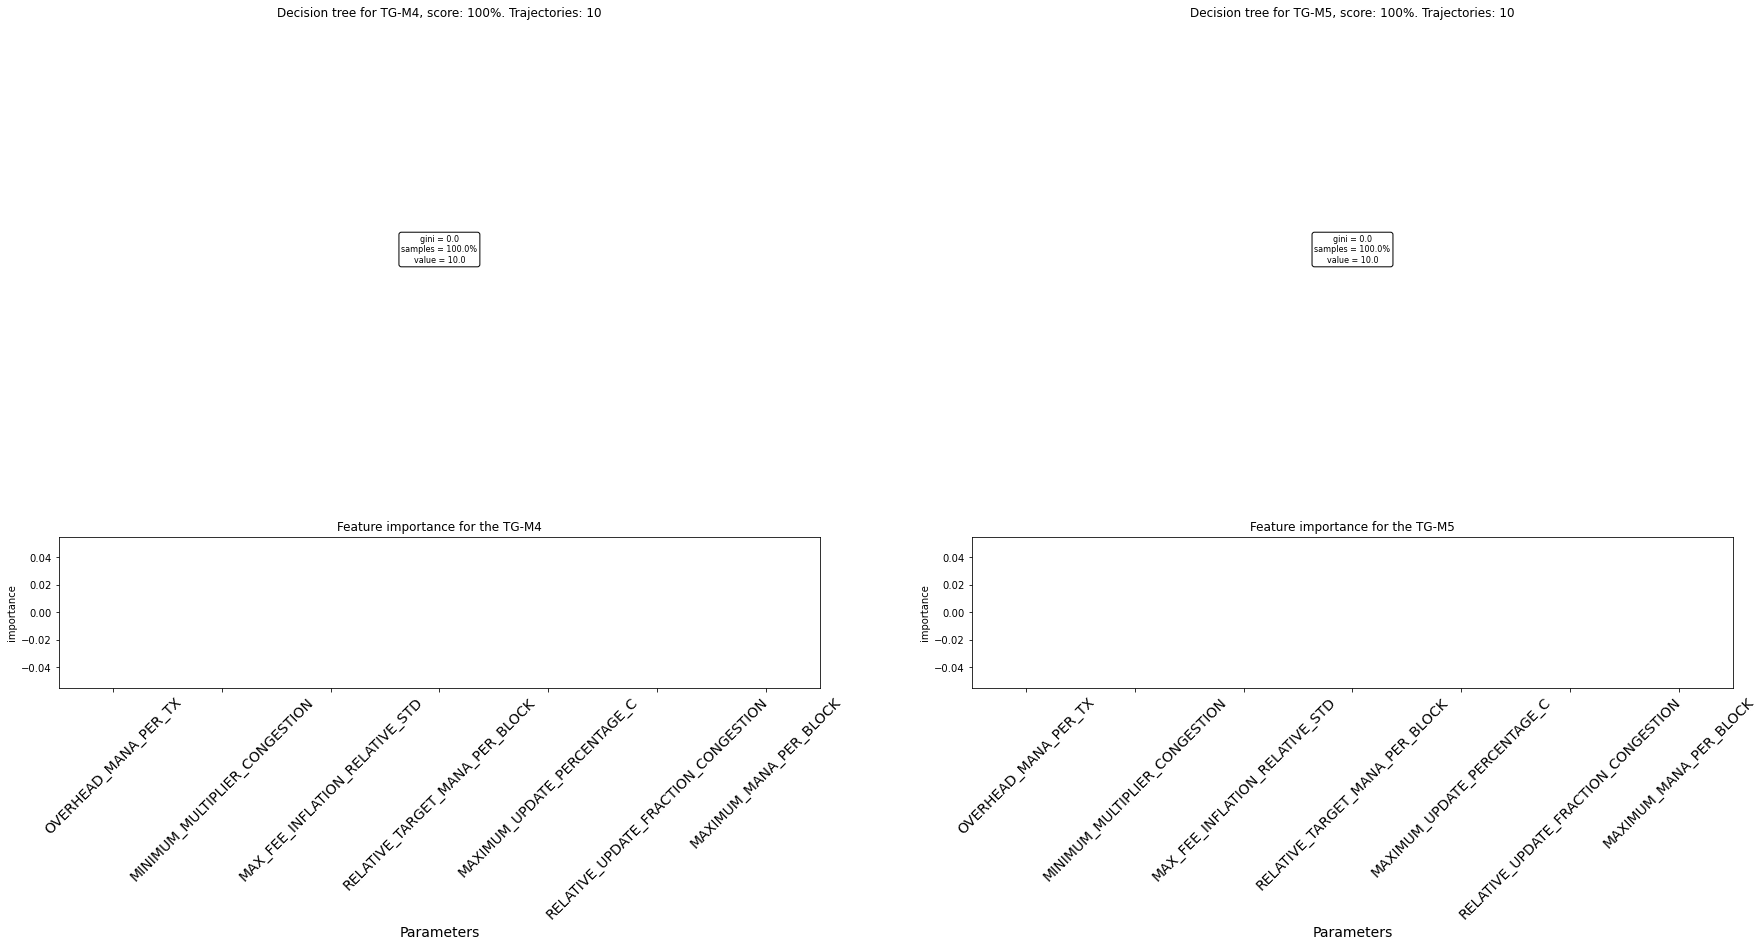

In [13]:
plot_agg_kpis(c_agg_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)

### Commentary on Results:

:dart: Write anything that comes up to mind based on the interpretation over all the results :dart: 

## Conclusion

- [ ] 🔫 Jakob owns after Danilo wrote commentary on results 🔫

## Appendix:
### Parameter Impact on Metrics: 

## 3. Shock Analysis

In [14]:
exp_spec = experiment_feemech_shock_analysis

# Override default configuration
exp_spec.N_timesteps = 1_000
exp_spec.N_samples = 1
exp_spec.N_config_sample = 10

CONTROL_PARAMS = list(exp_spec.params_swept_control.keys())

sim_df, exec_time = execute_sim(exp_spec.prepare())
agg_df, c_agg_df = retrieve_feature_df(sim_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 43, 10, 32)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 43, 10, 32)


Initializing configurations:   0%|          | 0/10 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/70010 [00:00<?, ?it/s]

Total execution time: 5.29s


### Objective 
As the fee mechanism is affected both by L1 congestion (through *limited L1 block space*, resulting in high gas and blob gas prices, as well as potential unavailability of settlement) and L2 congestion (through the *congestion component* of the fee mechanism), more insights are needed on the reaction of the fee mechanism to environmental shocks.
This scenario tests the resulting base fee and effects on included/excluded transactions when congestion shocks are introduced. This provides an insight into the resulting fee landscape under different control parameter constellations to further evaluate failure modes resulting from (direct and indirect) demand shocks. 

### Experimental Setup

#### Testing Variables: 
:dart: we should check the below variables 

##### Environmental:
* Simulating a time series for transactions volume representing low and high network congestion
* Shock scenarios on gas prices:
	i) strictly increase at maximum change throughout the simulation 
	ii) strictly decrease at maximum change throughout the simulation 
	iii) new values are drawn randomly from within the allowed range
	iv) stagnate without much change throughout the simulation


##### Protocol: 
 Assess the impact of different Base Fee related values. As the Base Fee is computed from various parametrizable components, this scenario tests a first group of parameter choices. This group consists of:
i)`OVERHEAD_MANA_PER_TX` - Each transaction incurs overhead mana costs, irrespective of any conducted operations. 
ii) `MAXIMUM_MANA_PER_BLOCK` - Each block is limited in *size* by this value, affecting profitability of sequencers, throughput of the network, and the computation of base fees directly. 
iii) `TARGET_MANA_PER_BLOCK` - This value is needed to compute the congestion component of the base fee. 
iv) `MAXIMUM_FEE_JUICE_PER_WEI_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real secondary market price updates. In other words, the real secondary market price can fluctuate freely (such as in a flashcrash), while the oracle value used in practice by users is limited in change. Through this the base fee might lag behind in its conversion component when compared to a "real" secondary market price value used in computation. 
v) `MAXIMUM_PROVING_COST_WEI_PER_MANA_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real proving cost updates. In other words, the proving cost experienced by Provers might differ from the oracle value used in practice by users. Through this the base fee might lag behind in its proving cost component when compared to a "real" secondary market price value used in computation. 

#### Simulation input/output per Monte Carlo run:

##### Input:
- Simulated time series for transactions volume representing "low" and "high" network congestion, where "low" is parameterized by a distribution with a mean μL and "high" is parameterized by a distribution with a mean μL+Δμ, with Δμ>0. The time series exhibits a "shock" from low to high congestion for a duration tμ, and subsequently returns to low congestion.
- Simulated time series for L1 gas prices (in ETH) representing "low" and "high" costs, where "low" is parameterized by a distribution with a mean γL and "high" is parameterized by a distribution with a mean γL+Δγ, with Δγ>0. The time series exhibits a "shock" from low to high L1 costs for a duration tγ, and subsequently returns to low costs.

##### Output:  
- The time series of the base fee
- The time series of available transactions included in each block
- The time series of available transactions excluded from each block
- Monte Carlo ($M$ runs indexed by $m$):
    - For each parameter constellation of interest, realizations of (Δμ,Δγ) and (tμ,tγ) are drawn from respective distributions with given (mean, variance) moments. Each pair may exhibit correlated or uncorrelated movements depending upon their respective covariance matrices.

#### Sweep Parameters:
Refer to the [spreadsheet](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=955157985#gid=955157985&range=A1) for detailed parameter configurations related to staking and slashing mechanisms.

:dart: Fill in :dart:

##### Control:

In [15]:
exp_spec.print_control_params()

MAX_FEE_INFLATION_RELATIVE_STD: [0.05, 0.1, 0.2]
RELATIVE_TARGET_MANA_PER_BLOCK: [0.5, 0.9]
MAXIMUM_MANA_PER_BLOCK: [20000000, 40000000]
MINIMUM_MULTIPLIER_CONGESTION: [1000000, 4000000, 10000000]
RELATIVE_UPDATE_FRACTION_CONGESTION: [0.1, 1.0, 10.0]
OVERHEAD_MANA_PER_TX: [1000, 10000, 50000]
MAXIMUM_UPDATE_PERCENTAGE_C: [0.01, 0.03]


##### Environmental:

In [16]:
exp_spec.print_env_params()

#### Simulation Behavior:
1. A sequencer will not post a block to L1 if the revenue from the block is less than the cost of posting the block.
2. A prover will not post a proof to L1 if the revenue from proving is less than the cost of posting the block.

#### Threshold Inequalities:

#### Metrics:
1. Average percentage of excluded transactions: $\bar{(\frac{T_I}{T_I+T_E})}$, where the average is taken over the M MC runs of values $\frac{T_I^m}{T_I^m+{T_E^m}}$ and ${T_I^m}$ and${T_E^m}$ are the total transactions included and excluded for MC run $m$, respectively.
Interpretation: Average percentage of excluded transactions: A high value indicates that the network congestion and/or L1 gas cost shocks impact the base fee to the extent that many otherwise available transactions are not included in a block.


2. Percentage of return to base fee ([PERCENTAGE_RETURN_TO_BASE_M](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=1840722092#gid=1840722092&range=A41)): The proportion of MC runs where the base fee returns to within a percentage of the base fee after the shock has concluded.
Interpretation: Percentage of return to base fee: A high percentage indicates that the fee mechanism is _resilient_ to congestion and/or L1 gas cost shocks, returning to a 'baseline' base fee value after the shock has passed.



#### Computational Complexity:

In [17]:
print(complexity_desc(sim_df, exec_time))


    #### Computational Complexity:
    1. Total number of parameter combinations: 10
    2. Total number of Monte Carlo runs per parameter combination: 10
    3. Total number of trajectories: 10
    4. Total number of timesteps per trajectory: 1,000
    5. Total number of state measurements: 10,010
    6. Workflow execution time: 8.08 seconds (0.808 seconds per trajectory)
    7. Engine execution time: 5.29 seconds (0.529 seconds per trajectory)
    


### Simulation Results 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart: 

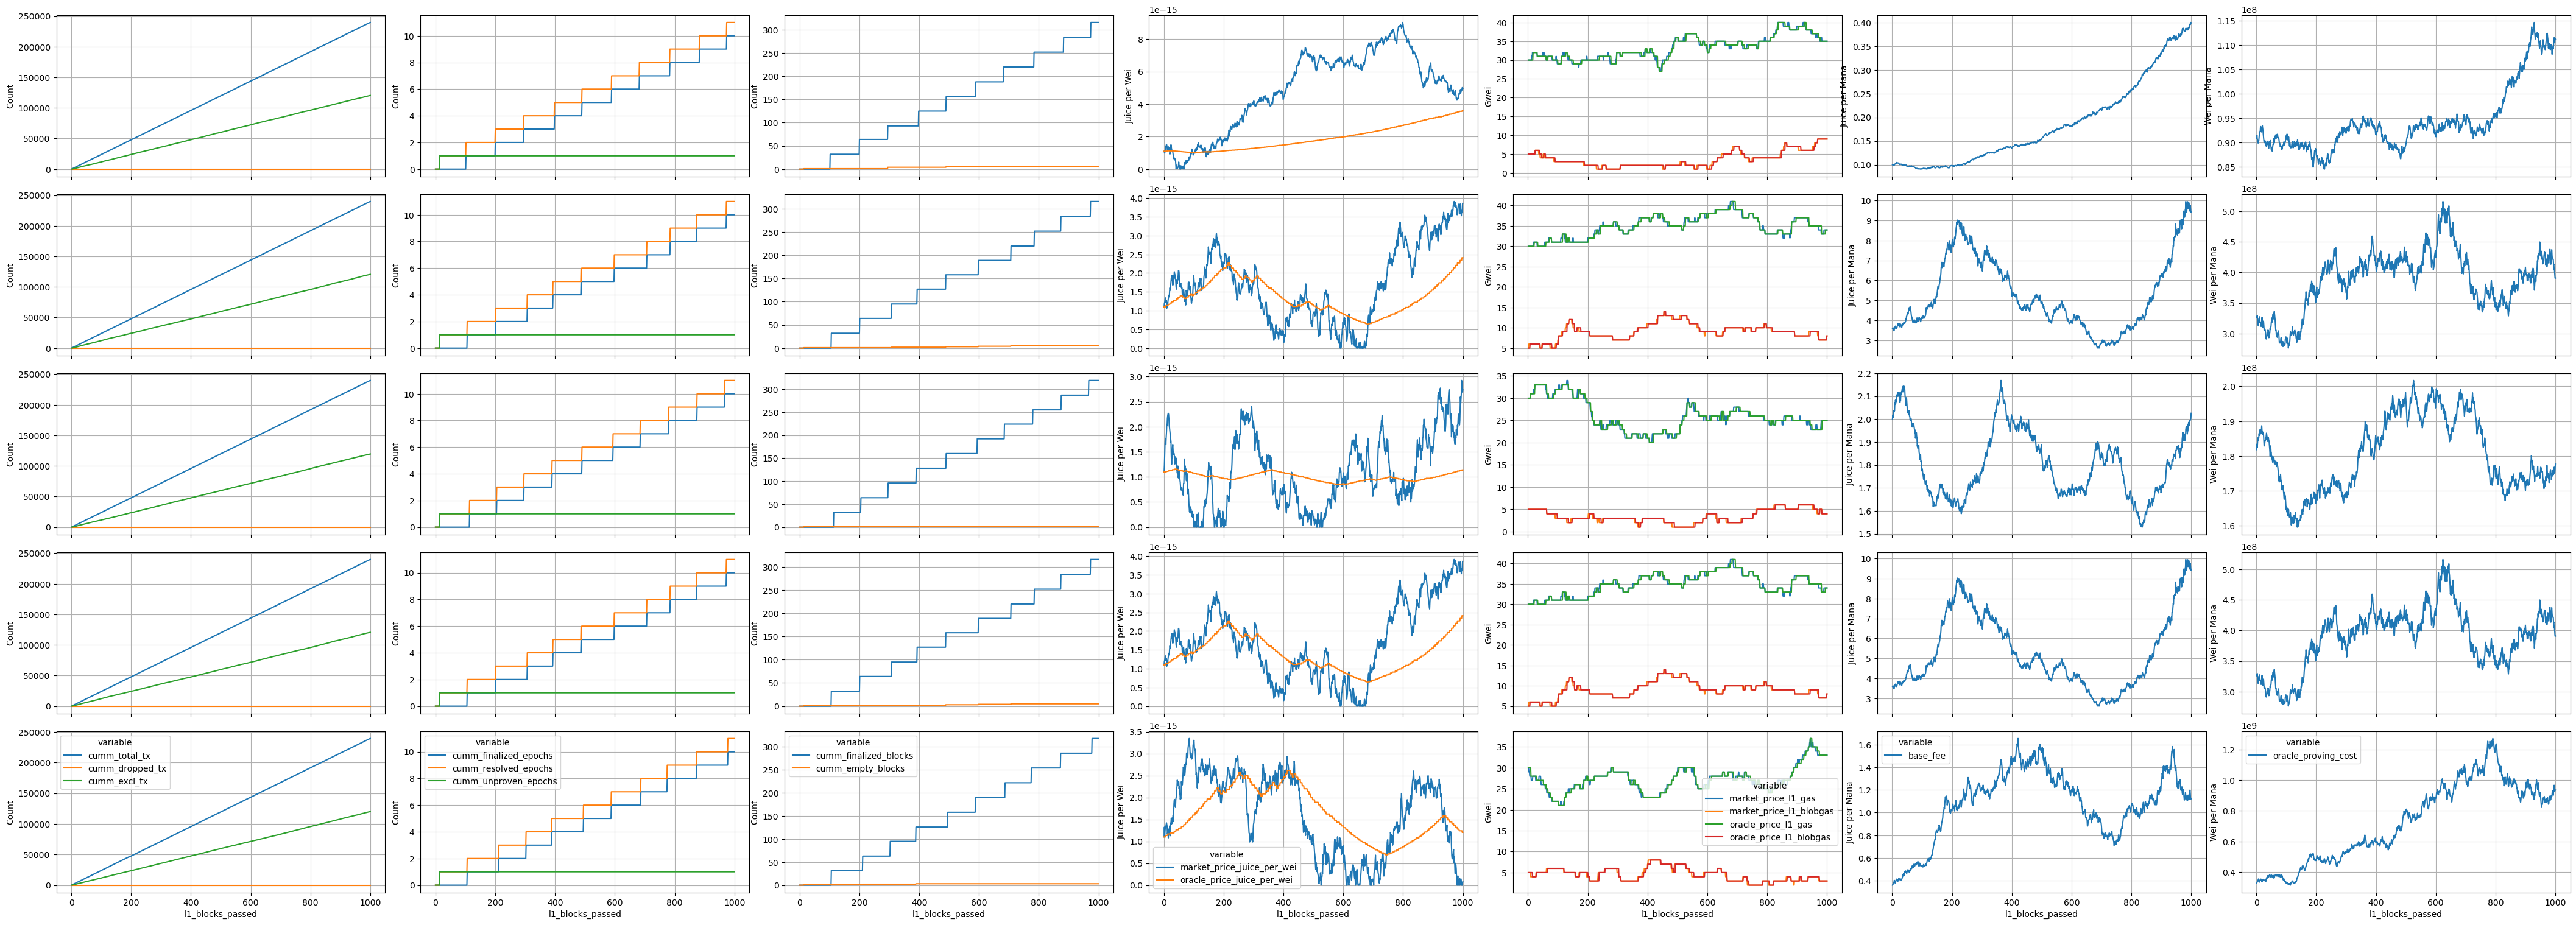

In [18]:
plot_inspect_vars(sim_df)

### Protocol Parameter Recommendations 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over table :dart: 
- [ ] :dart: Generate an analogue table below for the results :dart: 

### Decision Tree and Parameter Importance

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::
- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart:

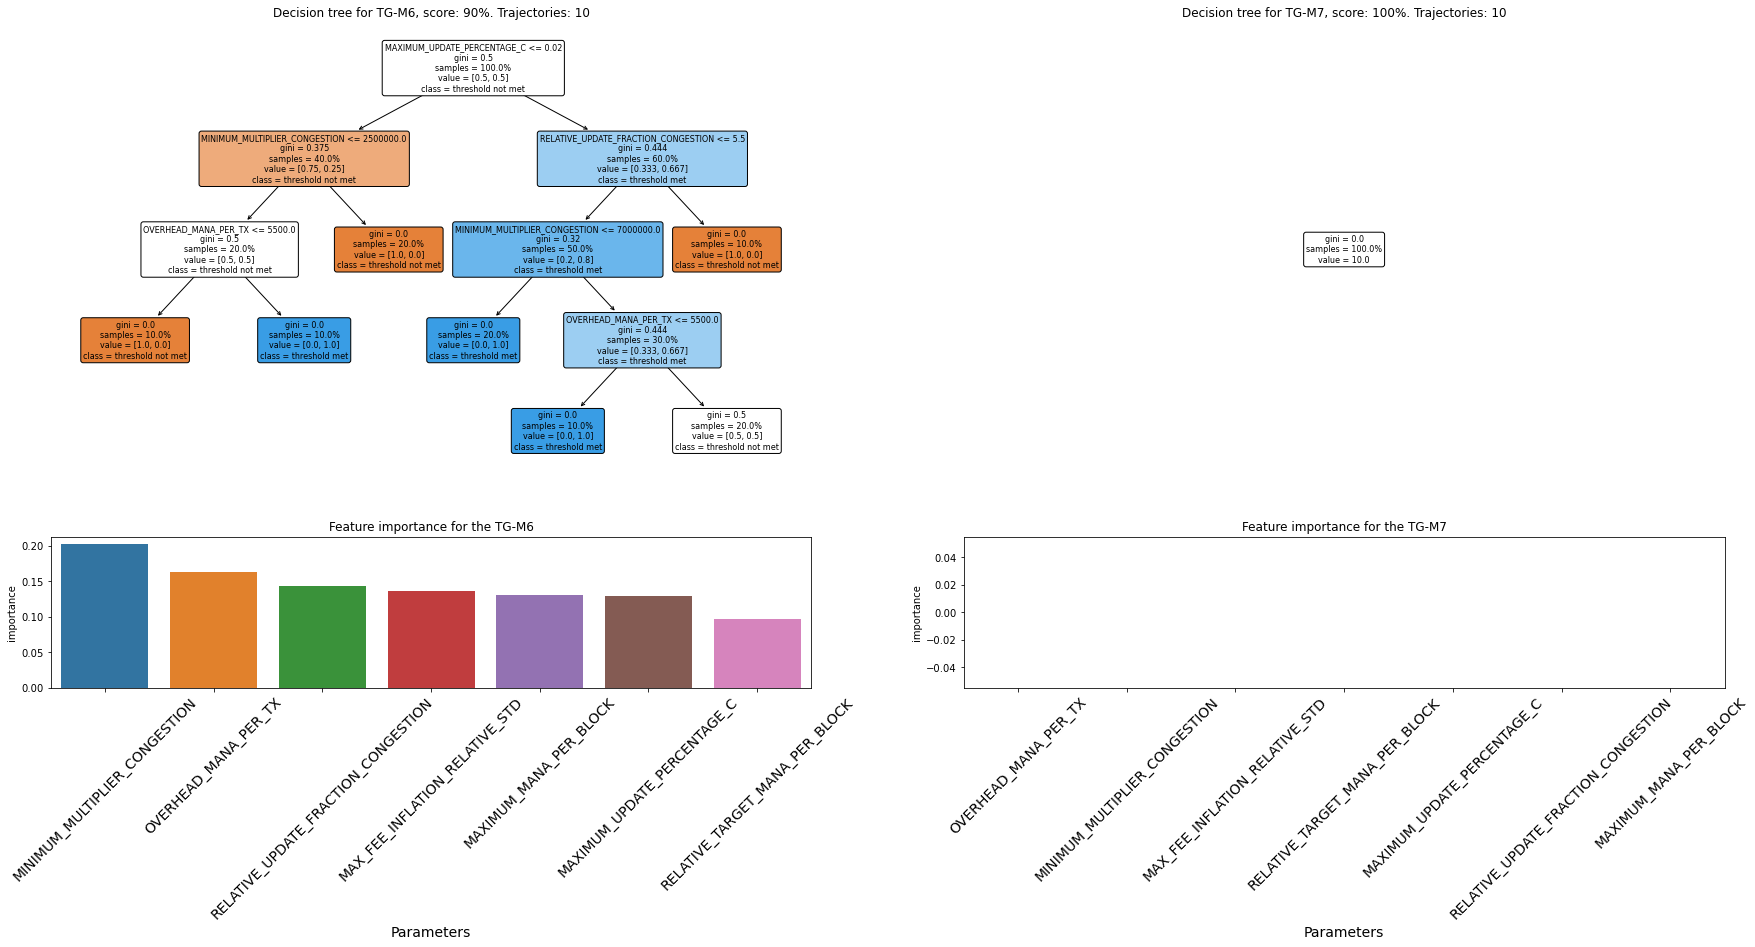

In [19]:
plot_agg_kpis(c_agg_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)

### Commentary on Results:

:dart: Write anything that comes up to mind based on the interpretation over all the results :dart: 

## Conclusion

- [ ] 🔫 Jakob owns after Danilo wrote commentary on results 🔫

## Appendix:
### Parameter Impact on Metrics: 

## 4. Oracle Sensitivity

In [28]:
exp_spec = experiment_feemech_oracle_sensitivity

# Override default configuration
exp_spec.N_timesteps = 1_000
exp_spec.N_samples = 1
exp_spec.N_config_sample = 10

CONTROL_PARAMS = list(exp_spec.params_swept_control.keys())

sim_df, exec_time = execute_sim(exp_spec.prepare())
agg_df, c_agg_df = retrieve_feature_df(sim_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 44, 10, 32)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 44, 10, 32)


Initializing configurations:   0%|          | 0/10 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/70010 [00:00<?, ?it/s]

Total execution time: 6.23s


### Objective 
The fee mechanism includes components relying on oracle values rather than having access to a (theoretical) "real" value. Considering that oracles might not be updated (and/or *updateable*) in real-time, and that their maximum change per update might be bounded, there can exist "lag" from "real" values to the oracle values used for the fee mechanism computation. If these values diverge through lag, users/sequencers/provers might not have access to a realistic cost / profit calculation. The Oracle Sensitivity scenario aims to evaluate the impact of oracle-driven parameters on the transaction fee mechanism within the Aztec network. 
This scenario specifically tests the susceptibility of the fee mechanism to errors propagated through oracle channels, which are external sources of truth not directly controlled by Aztec.

### Experimental Setup

#### Testing Variables: 
:dart: we should check the below variables 

##### Environmental:
** Simulating time series for oracle-driven parameters
* (Potential) Shock scenarios:
	i) strictly increase at maximum change throughout the simulation 
	ii) strictly decrease at maximum change throughout the simulation 
	iii) new values are drawn randomly from within the allowed range
	iv) stagnate without much change throughout the simulation

##### Protocol:
* Assess the impact of different Base Fee related values. As the Base Fee is computed from various parametrizable components, this scenario tests a first group of parameter choices. This group consists of:
	i)`OVERHEAD_MANA_PER_TX` - Each transaction incurs overhead mana costs, irrespective of any conducted operations. 
	ii) `MAXIMUM_MANA_PER_BLOCK` - Each block is limited in *size* by this value, affecting profitability of sequencers, throughput of the network, and the computation of base fees directly. 
	iii) `TARGET_MANA_PER_BLOCK` - This value is needed to compute the congestion component of the base fee. 
	iv) `MAXIMUM_FEE_JUICE_PER_WEI_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real secondary market price updates. In other words, the real secondary market price can fluctuate freely (such as in a flashcrash), while the oracle value used in practice by users is limited in change. Through this the base fee might lag behind in its conversion component when compared to a "real" secondary market price value used in computation. 
	v) `MAXIMUM_PROVING_COST_WEI_PER_MANA_PERCENT_CHANGE_PER_L2_SLOT` - This limits the useable space of real proving cost updates. In other words, the proving cost experienced by Provers might differ from the oracle value used in practice by users. Through this the base fee might lag behind in its proving cost component when compared to a "real" secondary market price value used in computation. 

#### Simulation input/output per Monte Carlo run:

##### Input:
Simulated time series of a single oracle parameter, which includes a deviation at a specified time period. This deviation is used to assess the impact on the base fee.

##### Output:  
- Time series of the Base Fee denominated in Asset per mana, capturing the periods before, during, and after the oracle parameter deviation.

- Monte Carlo ($M$ runs indexed by $m$):
    - For each parameter constellation of interest, create $M$ time series realizations (scenario-based or random outcome, as defined in **Simulation Behavior**) of the environmental parameters

#### Sweep Parameters:
Refer to the [spreadsheet](https://docs.google.com/spreadsheets/d/1EbW4sEYWb7iCjOYfgivNsLxe1O6ZFYwFSsRQjfiPLTM/edit?gid=955157985#gid=955157985&range=A1) for detailed parameter configurations related to staking and slashing mechanisms.

:dart: Fill in :dart:

##### Control:

In [29]:
exp_spec.print_control_params()

MAXIMUM_UPDATE_PERCENTAGE_C: [0.01, 0.03]


exp_spec.print_env_params()

In [30]:
exp_spec.print_env_params()

ORACLE_UPDATE_PRICE_FREQUENCY: [0.1, 0.5]
PROVING_COST_MODIFICATION_E: ['-', '=', '+']
FEE_JUICE_PRICE_MODIFICATION_E: ['-', '=', '+']


#### Simulation Behavior:
One environmental parameter is selected at a time from the list below:

- For PROVING_COST_MODIFICATION_E and FEE_JUICE_PRICE_MODIFICATION_E, these are set as potentially increasing, decreasing or constant functions over time (3 sub-scenarios in total)
- For ORACLE_UPDATE_FREQUENCY_E: this is the probability in any L2 block that the oracle could be updated. Whether or not the oracle is actually updated depends upon its last update time--an oracle value can only be updated if at least MIN_ORACLE_UPDATE_LAG_C (set to 5 in the simulations) has passed. 

#### Threshold Inequalities:

#### Metrics:
**Average Elasticity of the Base Fee:**
- Defined as the percentage change in the base fee divided by the percentage change in the oracle parameter, averaged over Monte Carlo runs.
Interpretation: A value of the metric greater than 1 indicates that the base fee is sensitive to changes in the oracle parameter, making it more susceptible to spurious errors (as modeled by the distribution that the errors are drawn from). A value less than 1 implies that the base fee is less sensitive to such changes, improving its predictability and 'inoculation' against spurious errors.

**Sequencer Losses:**
- Calculated as the average difference between the sequencer's revenue without oracle lag and the actual revenue with **MIN_ORACLE_UPDATE_LAG_C** in place.
Interpretation: A large positive value indicates that the sequencer has been negatively affected by oracle lag. Conversely, a negative value means that the sequencer actually benefited from the lag (this may be impossible given the way the base fee is computed).

#### Computational Complexity:

In [31]:
print(complexity_desc(sim_df, exec_time))


    #### Computational Complexity:
    1. Total number of parameter combinations: 10
    2. Total number of Monte Carlo runs per parameter combination: 10
    3. Total number of trajectories: 10
    4. Total number of timesteps per trajectory: 1,000
    5. Total number of state measurements: 10,010
    6. Workflow execution time: 9.49 seconds (0.949 seconds per trajectory)
    7. Engine execution time: 6.23 seconds (0.623 seconds per trajectory)
    


### Simulation Results 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart: 

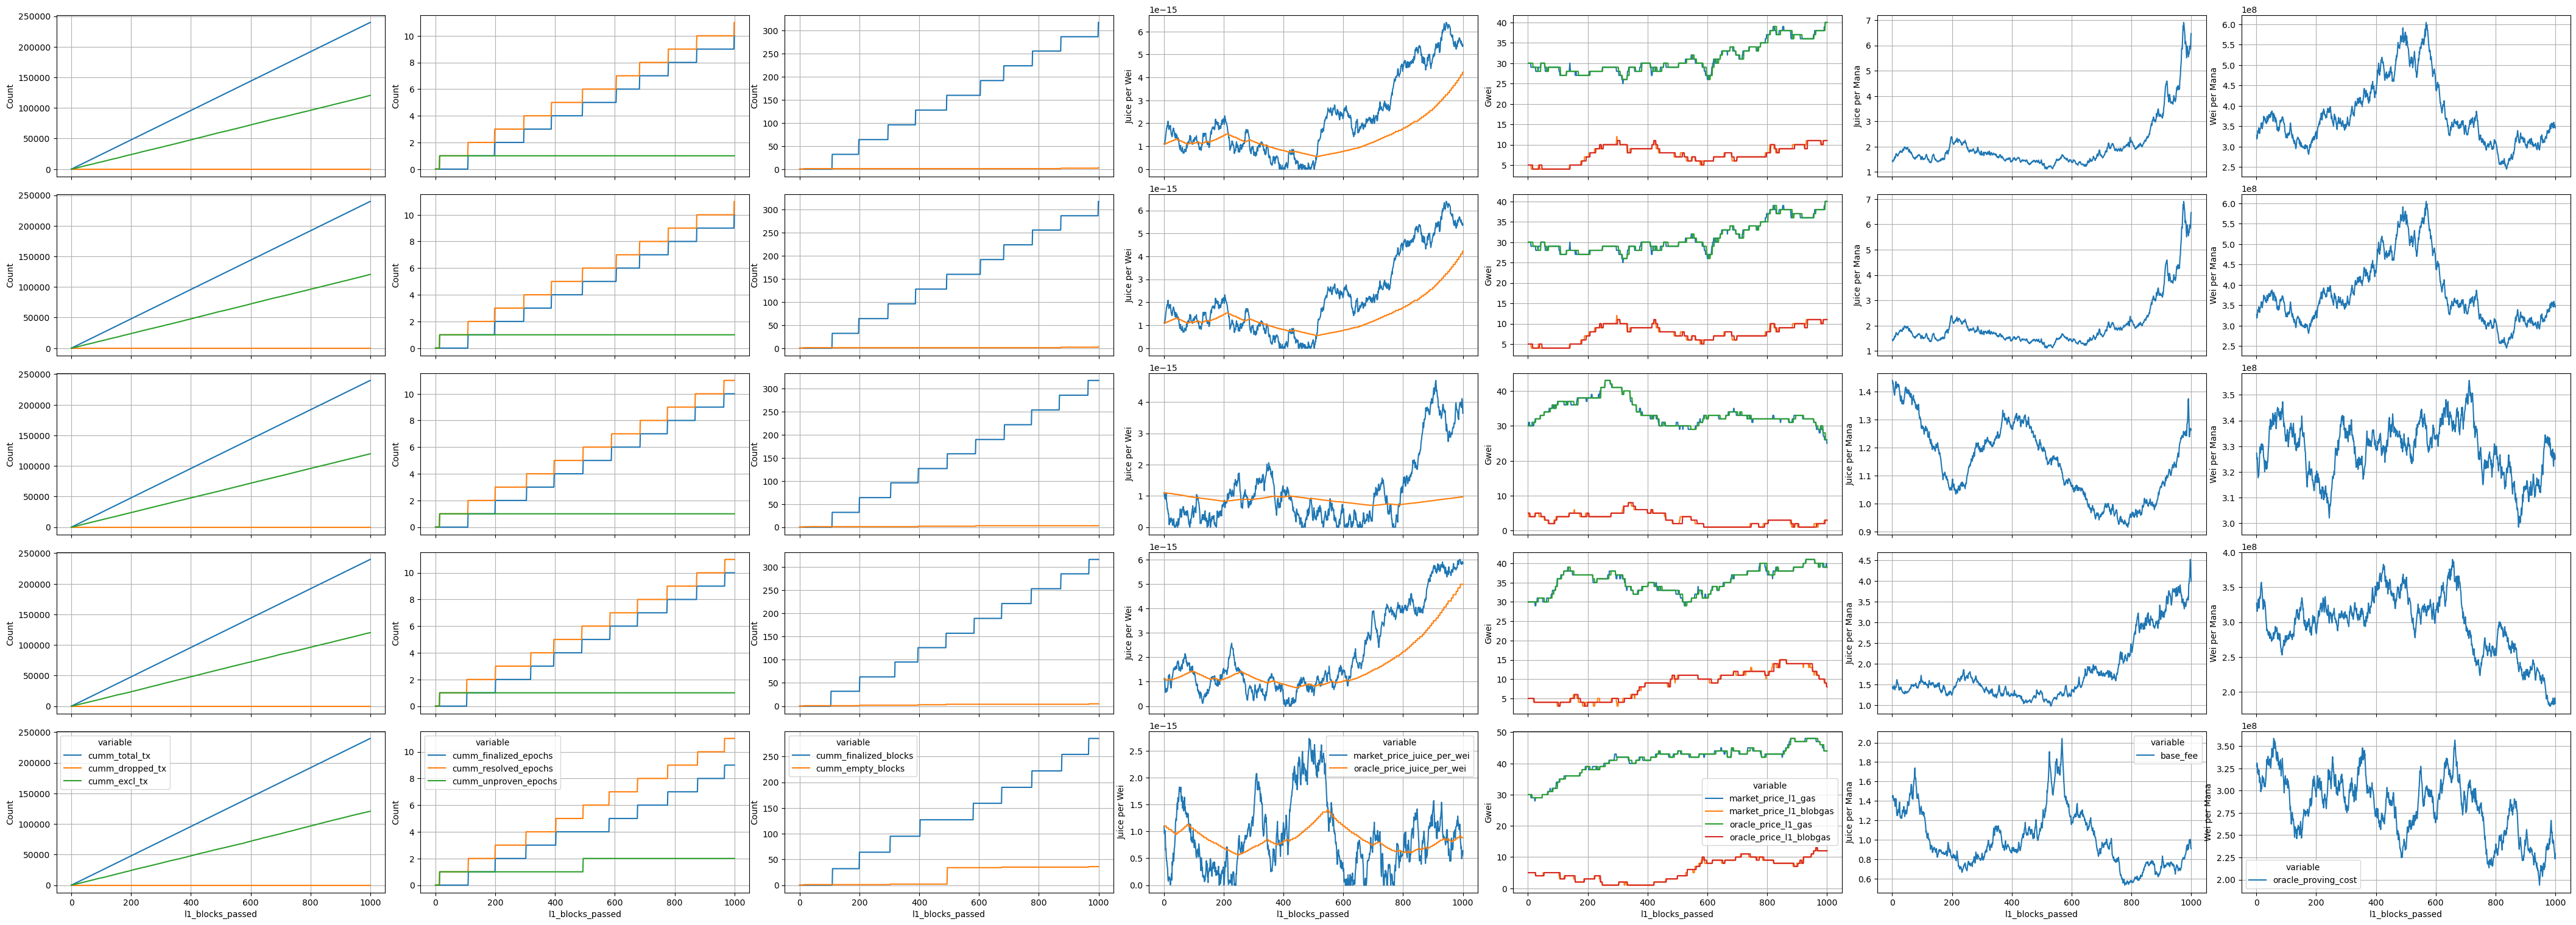

In [32]:
plot_inspect_vars(sim_df)

### Protocol Parameter Recommendations 

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::

- [ ] :dart: Write descriptive interpretation over table :dart: 
- [ ] :dart: Generate an analogue table below for the results :dart: 

### Decision Tree and Parameter Importance

:::info
See [main doc](https://hackmd.io/@blockscience/B1QKItvEye) for copyable explanations (or referenceable)
:::
- [ ] :dart: Write descriptive interpretation over the plot below :dart: 
- [ ] :dart: Generate an analogue plot below for the results :dart:

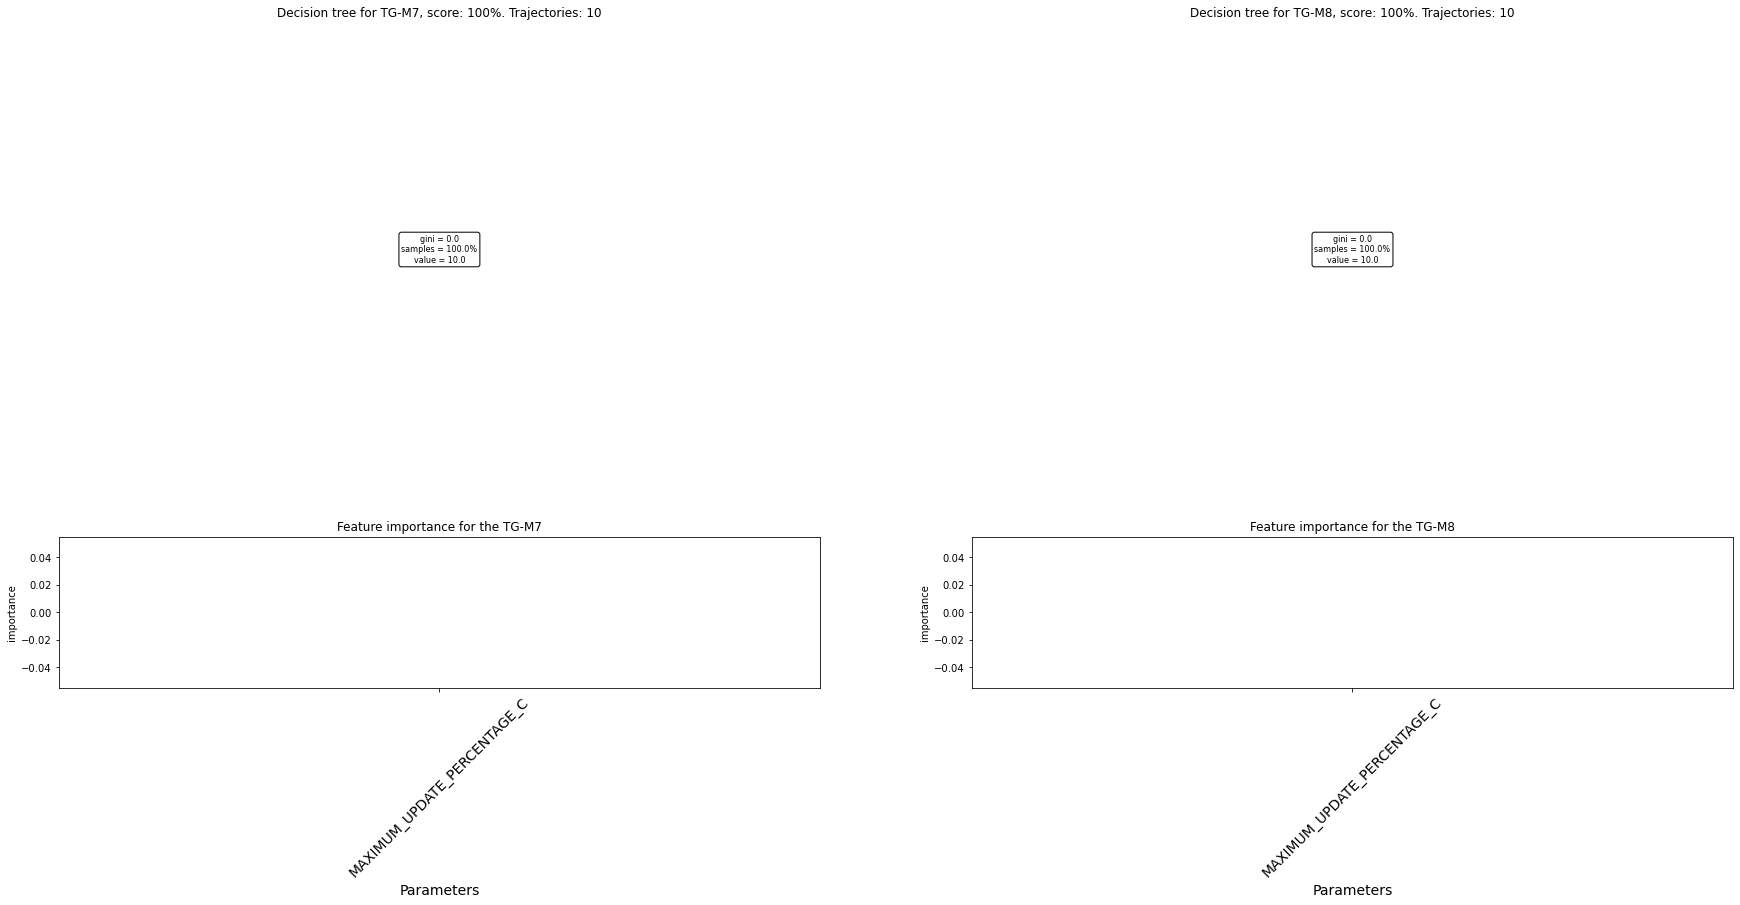

In [33]:
plot_agg_kpis(c_agg_df, CONTROL_PARAMS, exp_spec.relevant_per_trajectory_group_metrics)

### Commentary on Results:

:dart: Write anything that comes up to mind based on the interpretation over all the results :dart: 

## Conclusion

- [ ] 🔫 Jakob owns after Danilo wrote commentary on results 🔫

## Appendix:
### Parameter Impact on Metrics: 